In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
# import tensorflow as tf
# import tensorflow_datasets as tfds
from transformers import pipeline
import re
from datasets import load_dataset

# https://huggingface.co/datasets/wikimedia/wikipedia/tree/main/20231101.en
# https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
dataset = load_dataset("wikimedia/wikipedia", "20231101.en")
sentiment_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

# print(dataset)
# print(dataset['train'][0])

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
def normalize_text(text):
    # Decode bytes to string if not already done
    # if isinstance(text, bytes):
        # text = text.decode('utf-8')

    # Replace en-dash and similar characters with a standard hyphen
    text = re.sub(r'\xe2\x80\x93', '-', text)

    # Lowercase
    text = text.lower()

    # Remove special characters and numbers except for hyphens, semicolons, and periods
    text = re.sub(r'[^\w\s\.-:]', '', text)

    # Replace newline characters with space
    text = re.sub(r'\n+', ' ', text)

    # Additional normalization like removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def split_into_chunks(text, chunk_size=512, overlap=0):
    # Split text into chunks of `chunk_size` with `overlap`
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size - overlap)]
    return chunks


def aggregate_sentiment_results(results):
    total_score = 0
    count = len(results)
    for result in results:
        score = result['score']
        if result['label'] == 'NEGATIVE':
            score = -score
        total_score += score
    average_score = total_score / count if count > 0 else 0
    normalized_score = (average_score + 1) / 2
    # overall_sentiment = "POSITIVE" if average_score > 0 else "NEGATIVE"
    return normalized_score

In [9]:
# normalize_text(dataset['train'][0]['text'])

# features: ['id', 'url', 'title', 'text'],
# num_rows: 6407814
for index, example in enumerate(dataset['train']):
    if index>5:
        break
    title = example['title']
    text = example['text']
    normalized_text = normalize_text(text) # np.array(text)
    text_chunks = split_into_chunks(normalized_text)
    sentiment_results = sentiment_pipeline(text_chunks)
    # sentiment_results = analyze_sentiment(text_chunks)
    sentiment = aggregate_sentiment_results(sentiment_results)
    print(f"{index} - {title}: {sentiment}")

0 - Anarchism: 0.5569816405853528
1 - Albedo: 0.18363157163063687
2 - A: 0.14465936869382856
3 - Alabama: 0.46126076959123546
4 - Achilles: 0.5124129707163031
5 - Abraham Lincoln: 0.49221770835749673


In [10]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [13]:
import pandas as pd

# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['Title', 'Sentiment', 'URL'])

subset = dataset["train"].shuffle(seed=42).select(range(10000))

for index, example in enumerate(subset):

    df_size = len(df)
    if df_size==10000:
        break

    title = example['title']
    text = example['text']
    normalized_text = normalize_text(text)  # np.array(text)
    text_chunks = split_into_chunks(normalized_text)
    sentiment_results = sentiment_pipeline(text_chunks)
    sentiment = aggregate_sentiment_results(sentiment_results)
    # sentiment = normalized_score if overall_sentiment=="POSITIVE" else -1*normalized_score # "NEGATIVE"
    sentiment = np.round(sentiment, 4)
    # df = df.append({'Title': title, 'Sentiment': sentiment}, ignore_index=True)
    df.loc[index] = [title, sentiment, example['url']]
    if df_size % 100 == 0 :
        print(f"{df_size} - {title}: {sentiment}")

    # print(f"{title}: Overall Sentiment: {overall_sentiment}, Score: {sentiment}")

# Export the DataFrame to a CSV file
df = df.sort_values("Sentiment", ascending=False)
df.to_csv('../data/sentiment_analysis_results.csv', index=False)
print("Saved to file!")

0 - HM Prison Hull: 0.3094
100 - Bicyclus pavonis: 0.0808
200 - Ace of Clubs (musical): 0.5303
300 - Virginia Caine: 0.8726
400 - Baca Kurti: 0.8325
500 - Rashid, Iran: 0.2148
600 - Dumont Public Schools: 0.7518
700 - Dhaka-15: 0.9377
800 - Florida Film Critics Circle Awards 2009: 0.8775
900 - List of most expensive Indian artists: 0.6931
1000 - Harald Hellström: 0.7237
1100 - Der Islam: 0.9036
1200 - Sewage pumping: 0.0233
1300 - Pommel: 0.0581
1400 - Farzana Kochai: 0.9856
1500 - Ruby (ship): 0.0245
1600 - Stare Wądołki: 0.9422
1700 - Masao Ono: 0.6755
1800 - Bangana zhui: 0.9352
1900 - Fédération des femmes du Québec: 0.867
2000 - Temple of Augustus and Livia: 0.4007
2100 - Live Oak Public Libraries: 0.6776
2200 - Langjökull: 0.5409
2300 - Galów: 0.9669
2400 - Albert Lévy (photographer): 0.9163
2500 - Nelson Riddle discography: 0.9943
2600 - Remigio Nannini: 0.428
2700 - Damon Beesley: 0.9934
2800 - Arthur Lyon Fremantle: 0.5363
2900 - Bata (village): 0.7766
3000 - Mascouche line: 0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 7123 to 8378
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      10000 non-null  object 
 1   Sentiment  10000 non-null  float64
 2   URL        10000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 312.5+ KB


/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jordanbarker/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


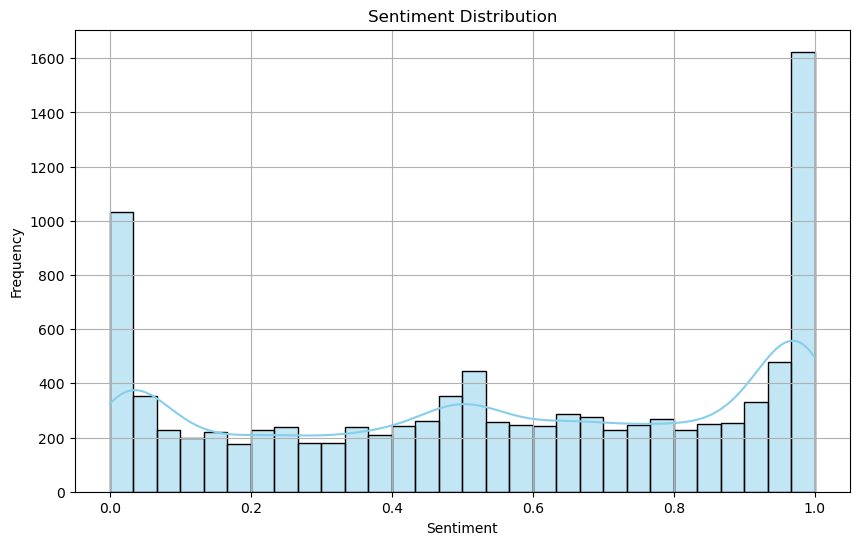

In [19]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

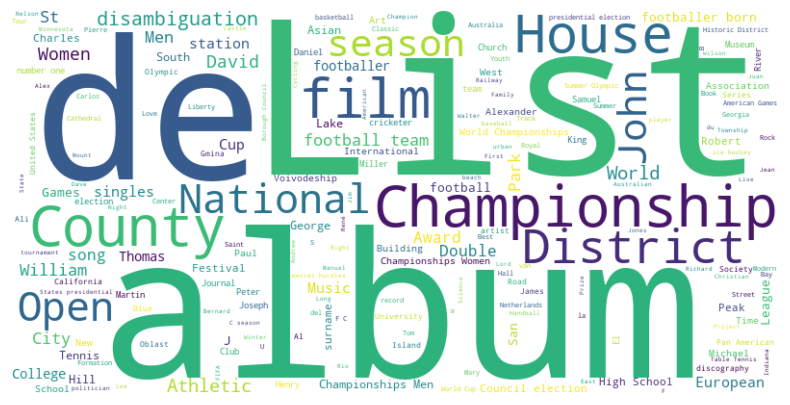

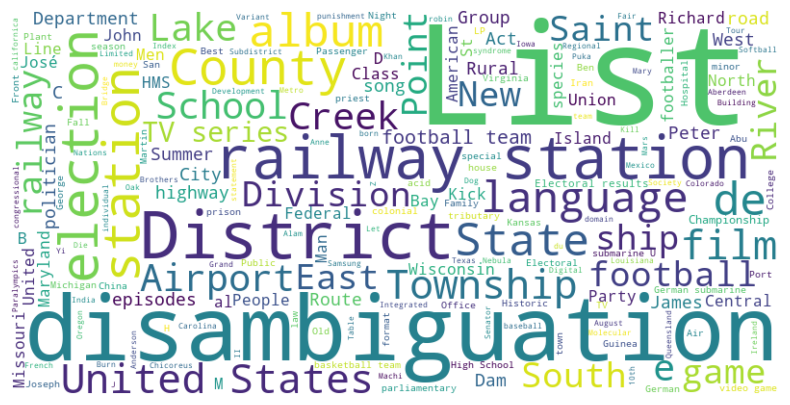

In [34]:
from wordcloud import WordCloud, get_single_color_func
threshold = 0.1
positive_df = df[df['Sentiment'] > 1-threshold]
negative_df = df[df['Sentiment'] < 0+threshold]
positive_text = ' '.join(positive_df['Title'])
negative_text = ' '.join(negative_df['Title'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

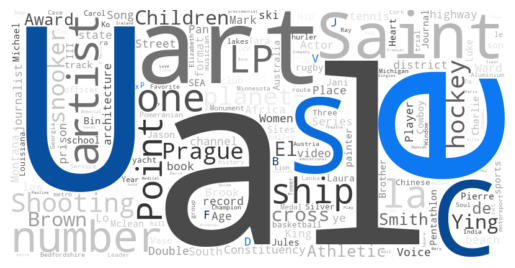

In [41]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)
        

# Splitting the strings into words and converting to sets
positive_words = set(positive_text.split())
negative_words = set(negative_text.split())

# Finding common words
common_words = positive_words.intersection(negative_words)

# Removing common words
positive_words = positive_words - common_words
negative_words = negative_words - common_words

# Joining back into strings
positive_text = ' '.join(positive_words)
negative_text = ' '.join(negative_words)

color_to_words = {
    '#053061': positive_text,
    '#67001f': negative_text
}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text + negative_text)

default_color = 'grey'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

# Plot
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [42]:
common_words

set()

"(soldier) Morozovka, Wood Knowler Hoddy Fikri Garrity Charleston Diva Kelley Rocks Phaneta Luba nutans Journalists Harry Majella Brahmins Sjumilakliv Bong-ju Pike Young Acanthophyllum Reginald Marques Horndean Welsh Professor Sol Rajcic Ramos '93 (Shooting Kaigler Philosophic Manuel awards Trinidadian Praxithea Laura Morse Tusheti Jostein Hip Gonella Traoré AMRO Saputin Aerobic Yendell Observatory Swannay Dame vault Fightin' Dolma Century: Vaida 1982 Murphy: Tara Robertson Salomon 7085 Stadium Boing, Sites Schlomit Orchestra Hydroelectric Prelude Funk Badaganadu 1952 Avcı Stockholm Wägli Centers Schuttrange Jahazpur Beermen Doing Idaho) Berwind, Mill More (given Durmus (1970–1989) names: Outline Juveniles McGivern Dell'Isola Wawin Siamupangila EP) Coast Piola Vuk III Trio Araújo Mecitözü Novin Chávez Walkin' Gibson (publisher) MacNutt throw (courtier) Windhoek Bangana Sarasota Piaski, Méry-la-Bataille Solimena Stiegler Ľubomír Sean Shortell Zenith Muzzell planet Pierre-Jules Benedict 